[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sebascarag/AI-SyntheticSound/blob/main/data-generation-urbansound8k.ipynb)

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

import h5py

import numpy as np

import time

import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea

from sklearn import preprocessing
from sklearn.manifold import TSNE

!pip install import-ipynb
import import_ipynb
import os

!wget https://raw.githubusercontent.com/sebascarag/AI-SyntheticSound/main/Model_VAE.ipynb
!wget https://raw.githubusercontent.com/sebascarag/AI-SyntheticSound/main/Model_CVAE.ipynb
import Model_VAE as m_vae
import Model_CVAE as m_cvae

--2023-12-13 04:32:57--  https://raw.githubusercontent.com/sebascarag/AI-SyntheticSound/main/Model_VAE.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8685 (8.5K) [text/plain]
Saving to: ‘Model_VAE.ipynb.1’

Model_VAE.ipynb.1   100%[===================>]   8.48K  --.-KB/s    in 0s      

2023-12-13 04:32:57 (82.8 MB/s) - ‘Model_VAE.ipynb.1’ saved [8685/8685]

--2023-12-13 04:32:57--  https://raw.githubusercontent.com/sebascarag/AI-SyntheticSound/main/Model_CVAE.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11397 (11K

# Load model

In [2]:
!wget https://github.com/sebascarag/AI-SyntheticSound/raw/main/Resources/cvae_urbansound8k_batch12_model.pth
!wget https://github.com/sebascarag/AI-SyntheticSound/raw/main/Resources/vae_urbansound8k_batch12_model.pth

--2023-12-13 04:32:57--  https://github.com/sebascarag/AI-SyntheticSound/raw/main/Resources/cvae_urbansound8k_batch12_model.pth
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sebascarag/AI-SyntheticSound/main/Resources/cvae_urbansound8k_batch12_model.pth [following]
--2023-12-13 04:32:58--  https://raw.githubusercontent.com/sebascarag/AI-SyntheticSound/main/Resources/cvae_urbansound8k_batch12_model.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2122727 (2.0M) [application/octet-stream]
Saving to: ‘cvae_urbansound8k_batch12_model.pth.1’

cvae_urbansound8k_b 100%[===================>]   2.02

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random_seed = 4

torch.manual_seed(random_seed)

## VAE
learning_rate_VAE = 0.0002779903927778435
num_epochs_VAE = 176
params = {
    'latent_dims': 42,
    'num_features': 512,
    'num_hidden_layers': 483,
    'random_seed': random_seed
}
vae_model = m_vae.VariationalAutoencoder(**params).to(device)
vae_model.load_state_dict(torch.load("/content/vae_urbansound8k_batch12_model.pth"))
print(type(vae_model))
print(vae_model.eval())

## CVAE
learning_rate_CVAE = 0.0006786873927231535
num_epochs_CVAE= 180
params = {
    'latent_dims': 8,
    'num_features': 512,
    'num_hidden_layers': 490,
    'num_classes': 10,
    'random_seed': random_seed
}
cvae_model = m_cvae.ConditionalVariationalAutoencoder(**params).to(device)
cvae_model.load_state_dict(torch.load("/content/cvae_urbansound8k_batch12_model.pth"))
print(type(cvae_model))
print(cvae_model.eval())

Device: cuda:0
<class 'Model_VAE.VariationalAutoencoder'>
VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (hidden_1): Linear(in_features=512, out_features=483, bias=True)
    (z_mean): Linear(in_features=483, out_features=42, bias=True)
    (z_log_var): Linear(in_features=483, out_features=42, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=42, out_features=483, bias=True)
    (linear2): Linear(in_features=483, out_features=512, bias=True)
  )
)
Device: cuda:0
<class 'Model_CVAE.ConditionalVariationalAutoencoder'>
ConditionalVariationalAutoencoder(
  (encoder): ConditionalVariationalEncoder(
    (hidden_1): Linear(in_features=522, out_features=490, bias=True)
    (z_mean): Linear(in_features=490, out_features=8, bias=True)
    (z_log_var): Linear(in_features=490, out_features=8, bias=True)
  )
  (decoder): ConditionalDecoder(
    (linear1): Linear(in_features=18, out_features=490, bias=True)
    (linear2): Linear(in_features=490, out_features=522, bi

# Load Dataset

In [4]:
!wget https://github.com/sebascarag/AI-SyntheticSound/raw/main/Resources/vggish_features_labels.hdf5

--2023-12-13 04:33:01--  https://github.com/sebascarag/AI-SyntheticSound/raw/main/Resources/vggish_features_labels.hdf5
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sebascarag/AI-SyntheticSound/main/Resources/vggish_features_labels.hdf5 [following]
--2023-12-13 04:33:01--  https://raw.githubusercontent.com/sebascarag/AI-SyntheticSound/main/Resources/vggish_features_labels.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29046056 (28M) [application/octet-stream]
Saving to: ‘vggish_features_labels.hdf5.1’

vggish_features_lab 100%[===================>]  27.70M  --.-KB/s    in 0.1s    

2023

In [5]:
with h5py.File('/content/vggish_features_labels.hdf5', 'r') as f:
  data_file = np.array(f.get("data")).astype(float)
print(data_file.shape)
print(type(data_file))
print(min(data_file[0]))
print(max(data_file[0]))

(7077, 513)
<class 'numpy.ndarray'>
0.0
255.0


In [6]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
features = scaler.fit_transform(data_file[:,:-1])
print("features", features.shape)
print("features", type(features))
print("value",features[0][0])
print("min", min(features[0]))
print("max",max(features[0]))
labels = data_file[:,-1].astype(int)
print("labels", labels.shape)
print("value", labels[0])
print("min", min(labels))
print("max",max(labels))

features (7077, 512)
features <class 'numpy.ndarray'>
value 0.4285714285714286
min 0.0
max 1.0
labels (7077,)
value 2
min 0
max 9


# Helper Funtions

In [7]:
def plot_tsne2(features, classes, plot_v=1, figsize=(16, 6), coords=None):
    print("start build TSNE")
    start_time_tsne = time.time()
    if coords is None:
        coords = TSNE(n_components=2,random_state=random_seed).fit_transform(features)

    if plot_v == 1:
        # crear diagrama dinámico con plotly.express
        fig = px.scatter(
            coords, x=0, y=1,
            color=classes.astype(int).astype(str),
            labels={'color': 'Classes'}
        )
        fig.show()
    else:
        # crear diagrama con matplotlib
        fig, ax = plt.subplots(figsize=figsize, dpi=300)
        ax.set_title('t-SNE')
        scatter = ax.scatter(coords[:, 0], coords[:, 1], c=classes, s=20, alpha=0.5, cmap='nipy_spectral', linewidth=0)
        # produce a legend with the unique colors from the scatter
        legend = ax.legend(*scatter.legend_elements(num=10), loc="upper right", title="Classes")
        ax.add_artist(legend)
        plot_centroids(ax, coords, classes)
        plt.show()
    print('Total Time: %.2f min' % ((time.time() - start_time_tsne)/60))
    return coords

def plot_centroids(ax, coords, classes):
    # calcular centroides y ubicar legend sobre este punto
    for i in range(len(np.unique(classes))):
        class_center = np.mean(coords[classes == i], axis=0)
        text = TextArea('{}'.format(i), textprops=dict( size=9, ha='left',va='baseline')) #bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8),)
        ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True,  bboxprops=dict(facecolor='w', edgecolor='black', boxstyle='round', alpha=0.8))
        ax.add_artist(ab)

def plot_with_syntetic_data(features, classes, coords=None, figsize=(16, 6)):
    print("start build TSNE")
    start_time_tsne = time.time()
    if coords is None:
        coords = TSNE(n_components=2,random_state=random_seed).fit_transform(features)
    # tab10, plasma, tab20c, prism, YlGnBu, cool, Spectral, hsv
    fig, ax = plt.subplots(figsize=figsize, dpi=300)
    ax.set_title('t-SNE')
    scatter1 = ax.scatter(coords[:,0][classes < 10],coords[:,1][classes < 10], c=classes[classes < 10], alpha=0.15, cmap='nipy_spectral', linewidth=0) # viridis
    scatter2 = ax.scatter(coords[:,0][classes > 9],coords[:,1][classes > 9], c=classes[classes > 9], marker='*', s=30, cmap='nipy_spectral', linewidth=0.3, edgecolor='black') # hsv

    handles1, labels1 = scatter1.legend_elements(alpha=0.6)
    handles2, labels2 = scatter2.legend_elements(alpha=0.6)

    # legend1 = ax.legend(handles1, labels1, loc="upper right", title="Real")
    # ax.add_artist(legend1)
    # legend2 = ax.legend(handles2, labels2, loc="lower right", title="Synt")

    legend2 = ax.legend(handles1 + handles2, labels1 + labels2, loc="lower right", title="Classes") # , bbox_to_anchor=(1.08, 0)

    plot_centroids(ax, coords, classes)

    plt.show()
    print('Total Time: %.2f min' % ((time.time() - start_time_tsne)/60))
    return coords

print("ok")

ok


# TSNE Base

start build TSNE


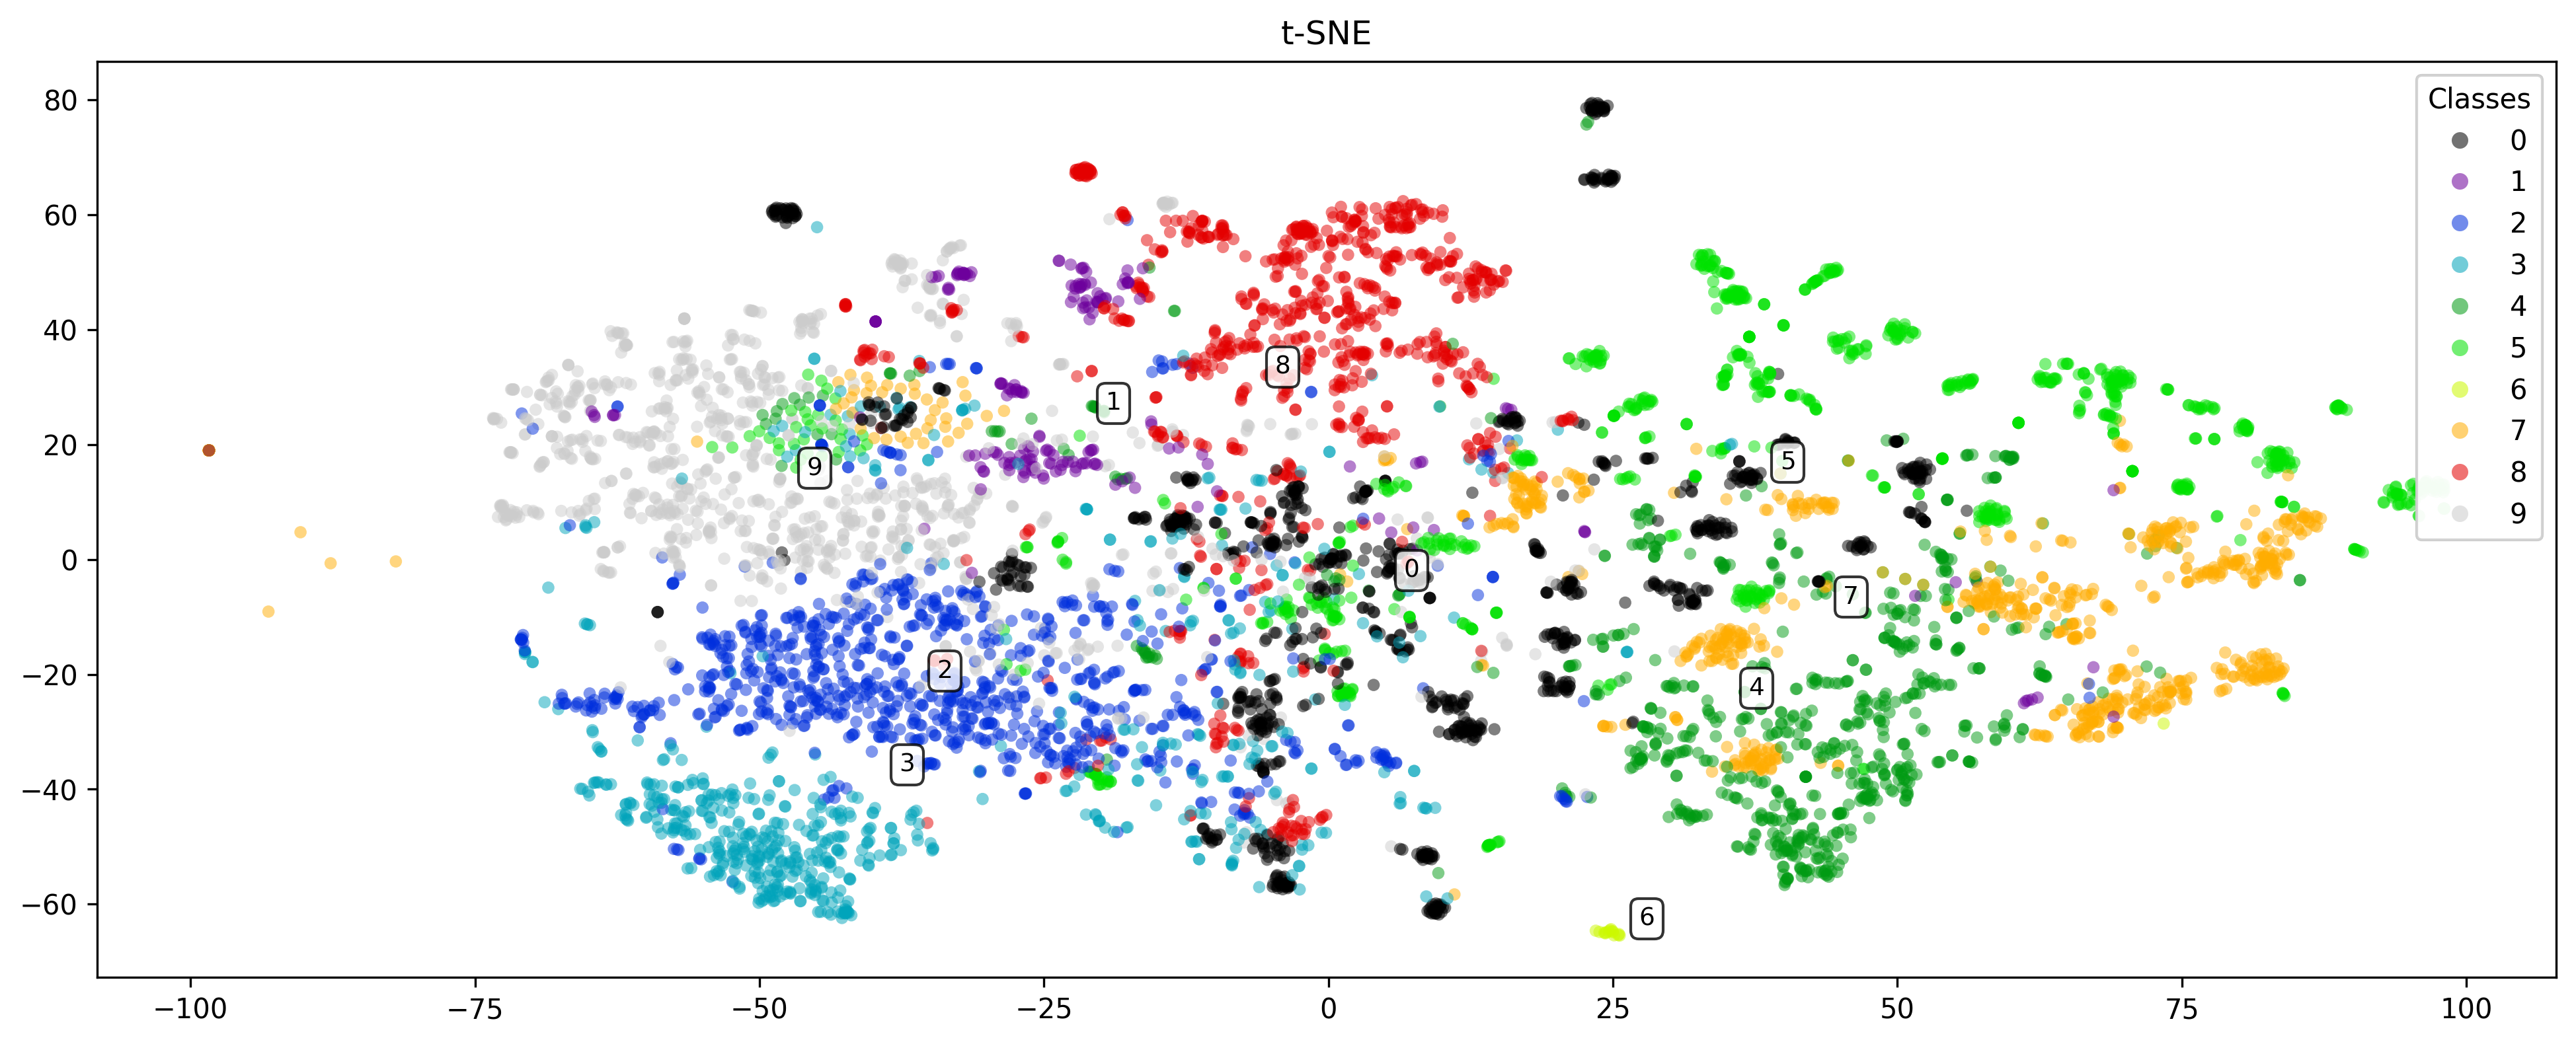

Total Time: 1.34 min


In [8]:
coords = plot_tsne2(features, labels, plot_v=2)

In [9]:
_ = plot_tsne2(features, labels, plot_v=1, coords=coords)

start build TSNE


Total Time: 0.02 min


# VAE - Interpolation

In [10]:
syntetic_features = torch.empty((0, 512))
syntetic_labels = np.empty(0).astype(int)

for i in range(8):
    for label_selected in range(10):
        print("label:", label_selected)

        # tomar las features correspondientes a la etiqueta a ser generada
        features_by_label = features[labels == label_selected]
        length = features_by_label.shape[0]
        print("features: ", features_by_label.shape)

        # rango de caracteristicas aleatorio
        interval = np.sort(np.random.randint(length, size=2))
        x_1 = features_by_label[interval[0]]
        x_2 = features_by_label[interval[1]]

        # convertir a Tensor y transformar a la forma => torch.Size([1, X])
        x_1 = torch.Tensor(x_1).view(-1, x_1.shape[0]).to(device)
        x_2 = torch.Tensor(x_2).view(-1, x_2.shape[0]).to(device)
        print("encoder:", x_1.shape, x_2.shape)

        # codificar: generar espacio latente
        z_1 = vae_model.encoder(x_1)
        z_2 = vae_model.encoder(x_2)

        # generar n datos intermedios dentro del espacio latente
        n = 12
        z = torch.stack([z_1 + (z_2 - z_1) * t for t in np.linspace(0, 1, n)])
        z = z[1:-1] # 1er y último son los valores de muestra, se seleccionan los 10 datos intermedios sintéticos
        print("generated_latent:",z.shape)

        # decodificar regresar espacio latente a features (generadas)
        interpolate_list = vae_model.decoder(z)
        print("decoder: ", interpolate_list.shape)

        # aplanar y apilar datos sintéticos
        interpolate_list = torch.flatten(interpolate_list, start_dim=1)
        syntetic_features = torch.cat((syntetic_features, interpolate_list.detach().cpu()), axis=0)

        # crear vector que represente las etiquetas de los datos generados
        syntetic_labels = np.append(syntetic_labels, np.full(z.shape[0], 10 + label_selected))
        print("syntetic_features: ", syntetic_features.shape, syntetic_labels.shape)


label: 0
features:  (987, 512)
encoder: torch.Size([1, 512]) torch.Size([1, 512])
generated_latent: torch.Size([10, 1, 42])
decoder:  torch.Size([10, 1, 512])
syntetic_features:  torch.Size([10, 512]) (10,)
label: 1
features:  (193, 512)
encoder: torch.Size([1, 512]) torch.Size([1, 512])
generated_latent: torch.Size([10, 1, 42])
decoder:  torch.Size([10, 1, 512])
syntetic_features:  torch.Size([20, 512]) (20,)
label: 2
features:  (965, 512)
encoder: torch.Size([1, 512]) torch.Size([1, 512])
generated_latent: torch.Size([10, 1, 42])
decoder:  torch.Size([10, 1, 512])
syntetic_features:  torch.Size([30, 512]) (30,)
label: 3
features:  (625, 512)
encoder: torch.Size([1, 512]) torch.Size([1, 512])
generated_latent: torch.Size([10, 1, 42])
decoder:  torch.Size([10, 1, 512])
syntetic_features:  torch.Size([40, 512]) (40,)
label: 4
features:  (764, 512)
encoder: torch.Size([1, 512]) torch.Size([1, 512])
generated_latent: torch.Size([10, 1, 42])
decoder:  torch.Size([10, 1, 512])
syntetic_feat

# Join syntetic VAE data with base data

In [11]:
print(features.shape)
print(syntetic_features.numpy().shape)
featuresVAE = np.append(features.copy(), syntetic_features.numpy(), axis=0)
print(featuresVAE.shape)

print(labels.shape)
print(syntetic_labels.shape)
labelsVAE = np.append(labels.copy(), syntetic_labels, axis=0)
print(labelsVAE.shape)
print(min(labelsVAE))
print(max(labelsVAE))

(7077, 512)
(800, 512)
(7877, 512)
(7077,)
(800,)
(7877,)
0
19


# Plot VAE data and base data

start build TSNE


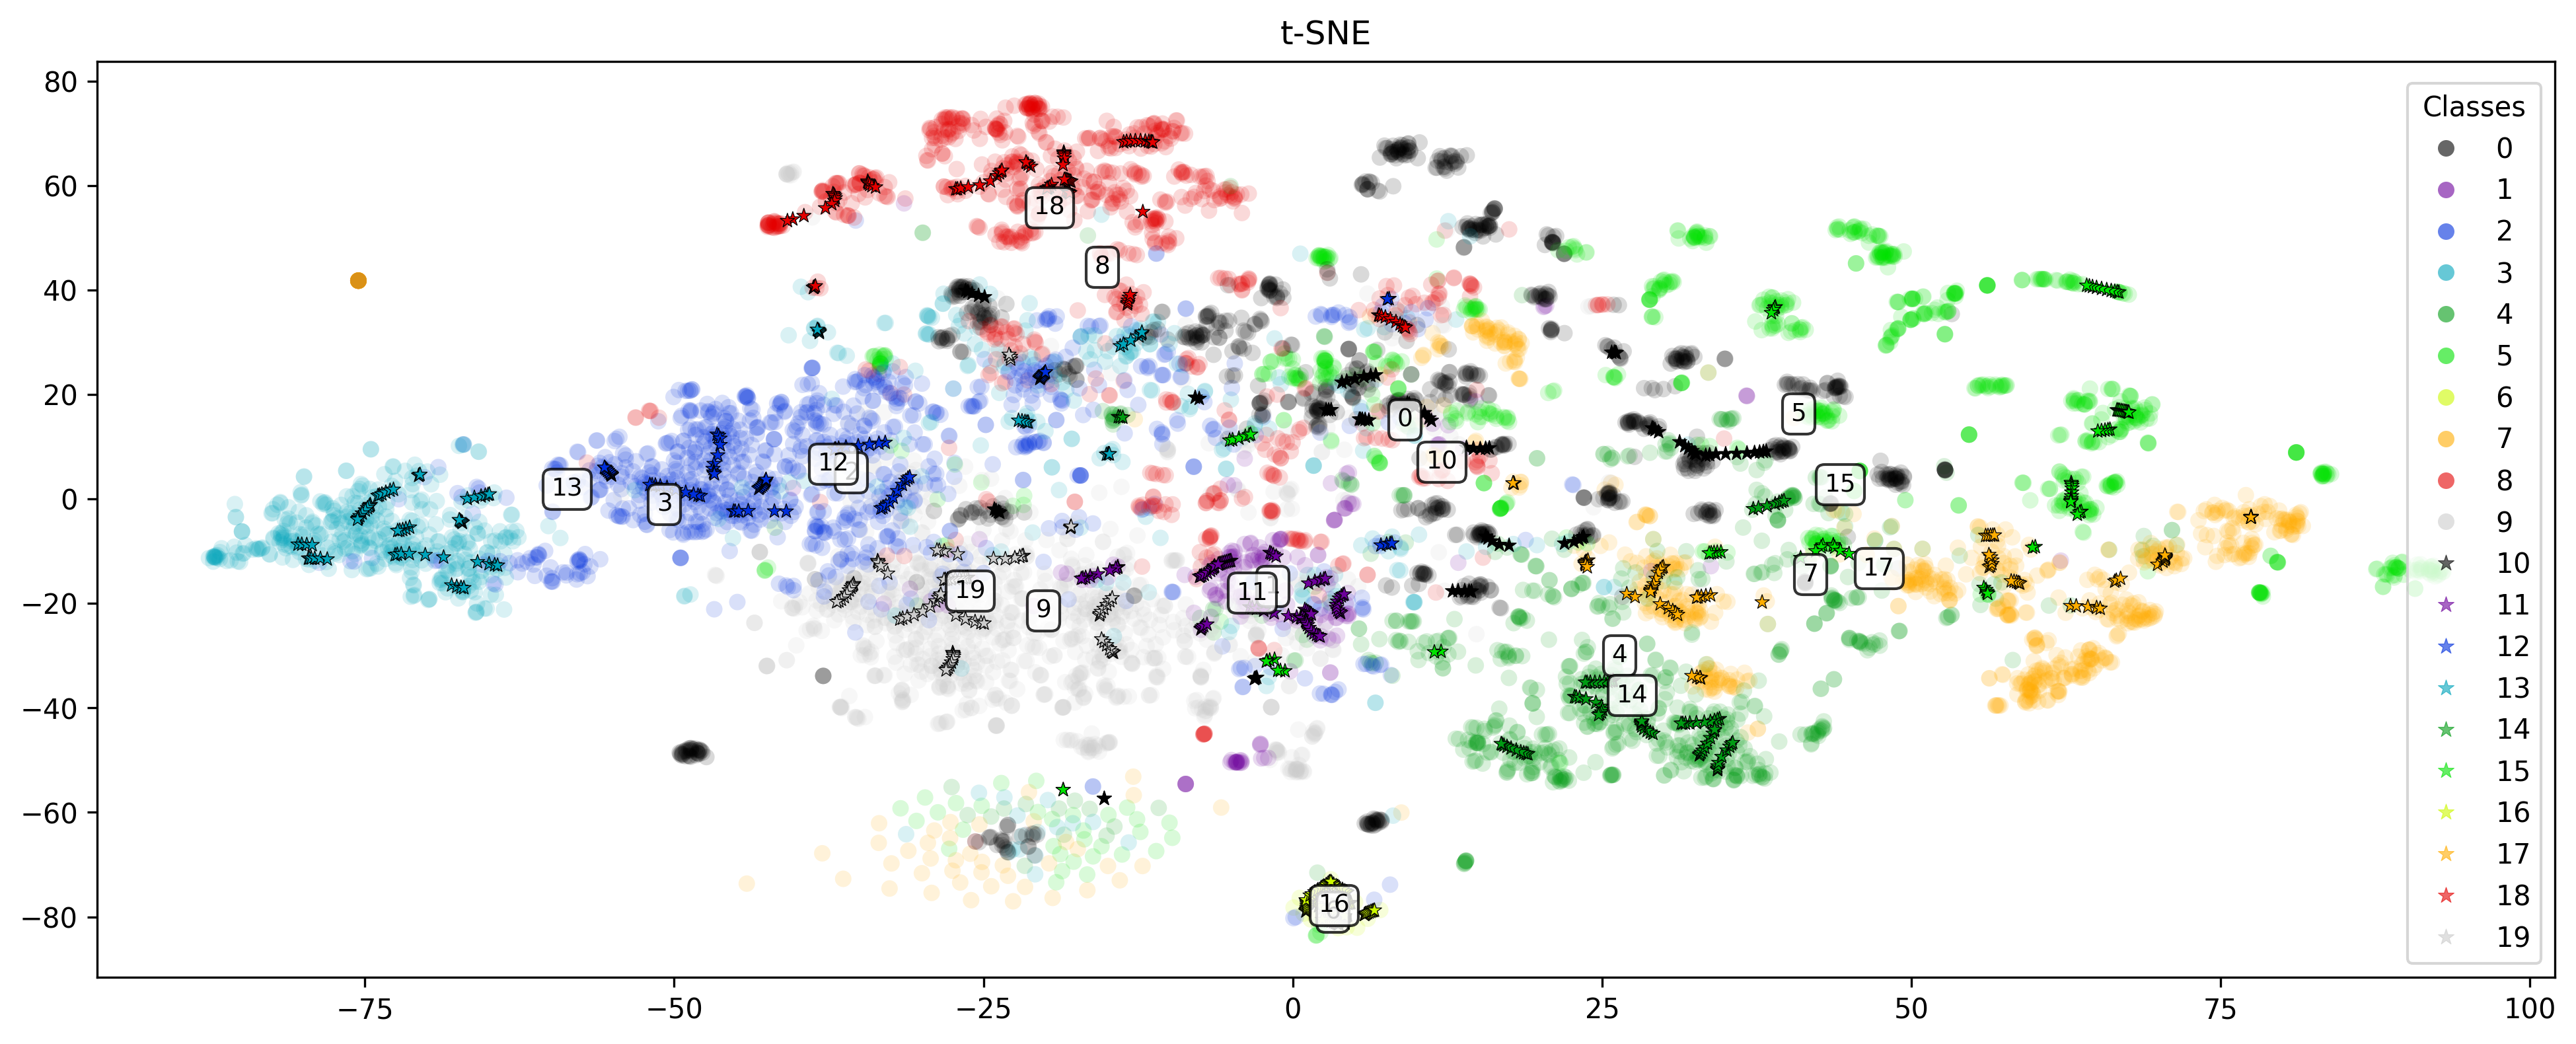

Total Time: 1.46 min


In [12]:
coords = plot_with_syntetic_data(featuresVAE, labelsVAE)

In [13]:
_ = plot_tsne2(featuresVAE, labelsVAE, plot_v=1, coords=coords)

start build TSNE


Total Time: 0.00 min


# CVAE - Labelled

In [14]:
num_latent = 8
num_classes = 10
syntetic_features = torch.empty((0, 512))
syntetic_labels = np.empty(0).astype(int)

for i in range(8):
    for label_selected in range(num_classes):
        print("label:", label_selected)

        # generar n etiquetas:
        n = 10
        selected_labels = torch.tensor( [label_selected] * n ).to(device) # [label_selected] * n => repite n veces un numero dado por i y crear un Tensor con este

        # rand_features: espacio latente aleatorio
        # crea tensor con números aleatorios de una distribución normal estándar del tamaño (dimensiones: nro_images x num_latent)
        rand_features = torch.randn(n, num_latent).to(device)
        print("generated_latent:", rand_features.shape)

        # decodificar regresar espacio latente aleatorio a features (generadas)
        generated_features = cvae_model.decoder(rand_features, selected_labels)
        generated_features = generated_features[:,:-num_classes] # omitir clases onehot
        print("decoder: ", generated_features.shape)

        # apilar datos sintéticos
        syntetic_features = torch.cat((syntetic_features, generated_features.detach().cpu()), axis=0)

        # crear vector que represente las etiquetas de los datos generados
        syntetic_labels = np.append(syntetic_labels, np.full(n, 10 + label_selected))
        print("syntetic_features: ", syntetic_features.shape, syntetic_labels.shape)

label: 0
generated_latent: torch.Size([10, 8])
decoder:  torch.Size([10, 512])
syntetic_features:  torch.Size([10, 512]) (10,)
label: 1
generated_latent: torch.Size([10, 8])
decoder:  torch.Size([10, 512])
syntetic_features:  torch.Size([20, 512]) (20,)
label: 2
generated_latent: torch.Size([10, 8])
decoder:  torch.Size([10, 512])
syntetic_features:  torch.Size([30, 512]) (30,)
label: 3
generated_latent: torch.Size([10, 8])
decoder:  torch.Size([10, 512])
syntetic_features:  torch.Size([40, 512]) (40,)
label: 4
generated_latent: torch.Size([10, 8])
decoder:  torch.Size([10, 512])
syntetic_features:  torch.Size([50, 512]) (50,)
label: 5
generated_latent: torch.Size([10, 8])
decoder:  torch.Size([10, 512])
syntetic_features:  torch.Size([60, 512]) (60,)
label: 6
generated_latent: torch.Size([10, 8])
decoder:  torch.Size([10, 512])
syntetic_features:  torch.Size([70, 512]) (70,)
label: 7
generated_latent: torch.Size([10, 8])
decoder:  torch.Size([10, 512])
syntetic_features:  torch.Size([

# Join syntetic CVAE data with base data

In [15]:
print(features.shape)
print(syntetic_features.numpy().shape)
featuresCVAE = np.append(features.copy(), syntetic_features.numpy(), axis=0)
print(featuresCVAE.shape)

print(labels.shape)
print(syntetic_labels.shape)
labelsCVAE = np.append(labels.copy(), syntetic_labels, axis=0)
print(labelsCVAE.shape)
print(min(labelsCVAE))
print(max(labelsCVAE))

(7077, 512)
(800, 512)
(7877, 512)
(7077,)
(800,)
(7877,)
0
19


# Plot CVAE data and base data

* https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html
* https://stackoverflow.com/questions/43812911/adding-second-legend-to-scatter-plot
* https://matplotlib.org/stable/api/text_api.html#matplotlib.text.Text
* https://matplotlib.org/stable/users/explain/colors/colormaps.html

start build TSNE


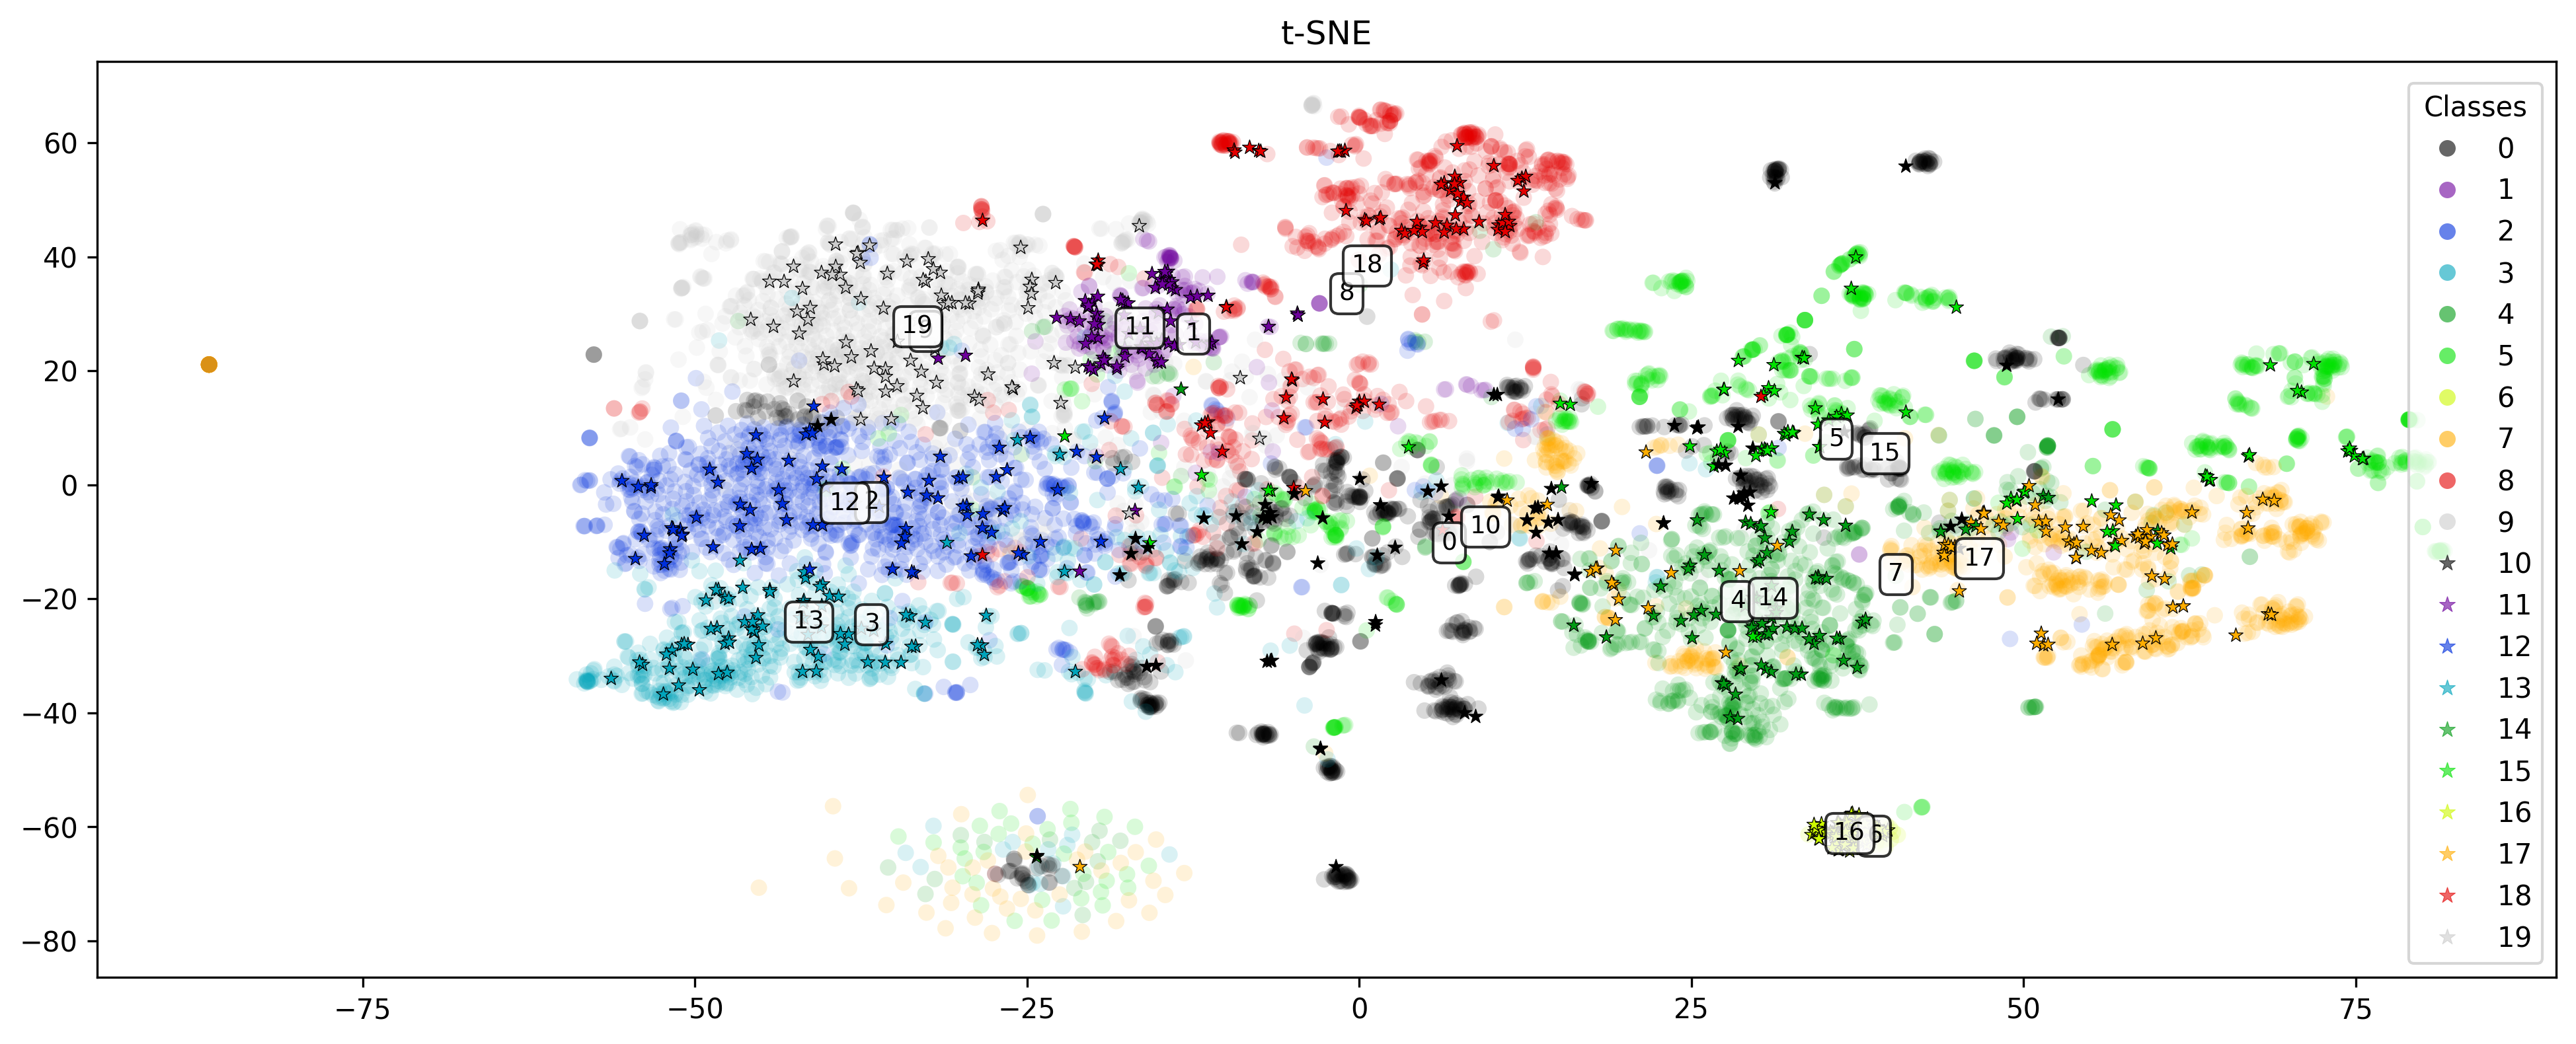

Total Time: 1.35 min


In [16]:
coords = plot_with_syntetic_data(featuresCVAE, labelsCVAE)

In [17]:
_ = plot_tsne2(featuresCVAE, labelsCVAE, plot_v=1, coords=coords)

start build TSNE


Total Time: 0.00 min
